In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.signal import peak_widths
from matplotlib.gridspec import GridSpec
import csv
import os
import ipympl
import pprint

class LaserData:
    def __init__(self,path):
        self.wavelenghts = np.array([229,233,237,241,245,249,253]) +780
        with open(path) as file:
            self.file = file
            self.file = csv.reader(self.file, delimiter='\t')
            self.time =[]
            self.piezo_voltage = []
            self.fabry_perot = []
            self.probe_laser = []
            self.laser_voltage = []
            for line in self.file:
                self.time.append(float(line[0]))
                self.piezo_voltage.append(float(line[1]))
                self.fabry_perot.append(float(line[2]))
                self.probe_laser.append(float(line[3]))
                self.laser_voltage.append(float(line[4]))
            self.time = np.array(self.time)
            self.piezo_voltage = np.array(self.piezo_voltage)
            self.fabry_perot = np.array(self.fabry_perot)
            self.probe_laser = np.array(self.probe_laser)
    
    def plot(self,with_peaks = False):
        fig = plt.figure(figsize=(11,6))
        gs = GridSpec(8,5)
        fig1 = fig.add_subplot(gs[:,:])
        fig1.plot(self.piezo_voltage,self.fabry_perot,'-')
        #fig1.plot(self.time,self.piezo_voltage)
        if with_peaks:
            peaks,_ = find_peaks(self.fabry_perot,prominence=0.3,height=0.8)
            print(len(peaks))
            for peak in peaks:
                fig1.plot(self.piezo_voltage[peak],self.fabry_perot[peak],'go')
        fig1.set_xlabel('Zeit in s',fontsize = 15)
        fig1.set_ylabel('Spannung in V',fontsize = 15)

    def slice_data(self, idx_start, idx_stop):
        # deletes the data outside the given index_range
        self.time = self.time[idx_start:idx_stop] - self.time[idx_start]
        self.piezo_voltage = self.piezo_voltage[idx_start:idx_stop]
        self.fabry_perot = self.fabry_perot[idx_start:idx_stop]
        self.probe_laser = self.probe_laser[idx_start:idx_stop]
        self.laser_voltage = self.laser_voltage[idx_start:idx_stop]

    

laser = LaserData('Data/spektrum_dopplerfrei_mit_pump_freq4.dat') 

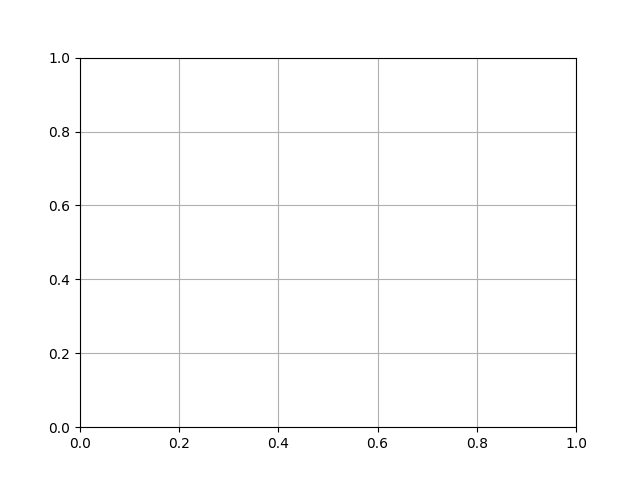

In [2]:
laser = LaserData('Data/spektrum_dopplerfrei_ohne_pump_freq3.dat')
idx_start = np.argmax(laser.piezo_voltage)
idx_stop  = np.argmin(laser.piezo_voltage)

laser.slice_data(idx_start, idx_stop)

#filter data
laser.piezo_voltage = savgol_filter(laser.piezo_voltage, 1000, 1)
laser.fabry_perot = savgol_filter(laser.fabry_perot, 50, 6)
%matplotlib widget
plt.clf()
#plt.plot(piezo2wavelength(5*laser.piezo_voltage)-780, laser.probe_laser)
plt.grid()
plt.show()

# Nicht dopplerfrei

In [3]:
def piezo2wavelength(voltage, freq=3):
    # returns the corresponding wavelength fot given Piezo voltage
    # by given freqency setting (1, 3, 4, 6). Default is freq=3
    #korrespondierende Wellenlängen
    wavelengths_nm = np.array([229, 233, 237, 241, 245, 249]) * 10**(-3) + 780

    laser = LaserData(f'Data/spektrum_dopplerfrei_ohne_pump_freq{freq}.dat')
    #starting time
    idx_start = np.argmax(laser.piezo_voltage)
    idx_stop  = np.argmin(laser.piezo_voltage)

    laser.slice_data(idx_start, idx_stop)

    #filter data
    laser.piezo_voltage = savgol_filter(laser.piezo_voltage, 1000, 1)
    laser.fabry_perot = savgol_filter(laser.fabry_perot, 50, 6)

    peaks, _ = find_peaks(laser.fabry_perot,prominence=0.05,height=0.8)

    if freq==1:
        x, y = 5 * laser.piezo_voltage[peaks[1:7]], wavelengths_nm
    else:
        x, y = 5 * laser.piezo_voltage[peaks], wavelengths_nm

    reg = sp.stats.linregress(x, y)

    return reg.slope * voltage + reg.intercept


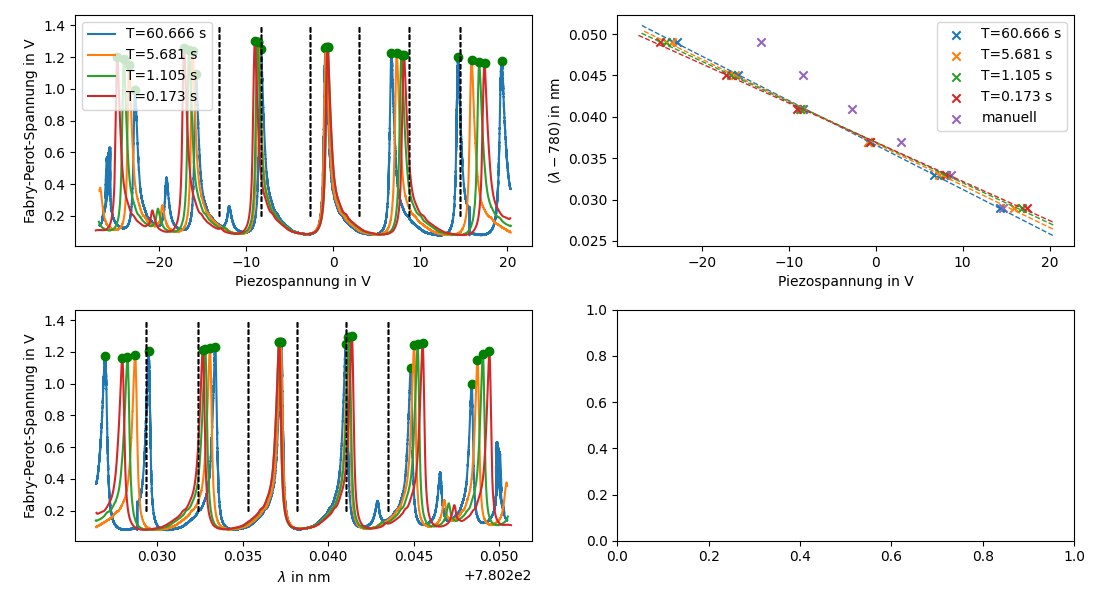

In [4]:
#relevante files einlesen
filenames = sorted([file for file in os.listdir('Data/') if file.__contains__('dopplerfrei_ohne_pump_freq')])

#new figure
%matplotlib widget
#plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(11,6))

#Piezo-Spannungen für die händisch gemessenen Peaks (für absteigende Spannung)
peaks_manuell_V = np.array([-13.2, -8.36, -2.67, 2.96, 8.70, 14.6])[::-1]

#korrespondierende Wellenlängen
wavelengths_nm = np.array([229, 233, 237, 241, 245, 249]) * 10**(-3) + 780

for k, file in enumerate(filenames):
    laser = LaserData('Data/'+file)

    #starting time
    idx_start = np.argmax(laser.piezo_voltage)
    idx_stop  = np.argmin(laser.piezo_voltage)

    t_start = laser.time[idx_start]
    t_stop = laser.time[idx_stop]

    period = 2 * (t_stop - t_start)

    
    laser.slice_data(idx_start, idx_stop)
    #plt.plot(laser.piezo_voltage)
    laser.piezo_voltage = savgol_filter(laser.piezo_voltage, 1000, 1)
    laser.fabry_perot = savgol_filter(laser.fabry_perot, 50, 6)
    
    peaks,_ = find_peaks(laser.fabry_perot,prominence=0.05,height=0.8)
    
    ###################################plot (0, 0)#############################################
    ax = axes[0, 0]
    ax.plot(5 * laser.piezo_voltage, laser.fabry_perot, label=f'T={period:.3f} s')
    for peak in peaks:
        ax.plot(5 * laser.piezo_voltage[peak], laser.fabry_perot[peak],'go')

    for i, peak in enumerate(peaks_manuell_V):
        ax.plot(np.array([peak, peak]), [0.2, 1.4],'--', color='black', linewidth=1)
    
    ###################################plot (0, 1)#############################################
    ax = axes[0, 1]
    if k==0:
        ax.scatter(5 * laser.piezo_voltage[peaks[1:7]], wavelengths_nm-780.2, marker='x', label=f'T={period:.3f} s')
    else:
        ax.scatter(5 * laser.piezo_voltage[peaks], wavelengths_nm-780.2, marker='x', label=f'T={period:.3f} s')
    ax.plot(5 * laser.piezo_voltage, piezo2wavelength(5 * laser.piezo_voltage, freq=int(file[-5]))-780.2, '--', linewidth=1)


    ###################################plot (1, 0)#############################################
    ax = axes[1, 0]

    ax.plot(piezo2wavelength(5 * laser.piezo_voltage), laser.fabry_perot, label=f'T={period:.3f} s')
    for peak in peaks:
        ax.plot(piezo2wavelength(5 * laser.piezo_voltage[peak]), laser.fabry_perot[peak],'go')

    for i, peak in enumerate(peaks_manuell_V):
        ax.plot(piezo2wavelength(np.array([peak, peak])), [0.2, 1.4],'--', color='black', linewidth=1) 





ax = axes[0, 1]
ax.scatter(peaks_manuell_V, wavelengths_nm-780.2, marker='x', label='manuell')

ax = axes[0, 0]
ax.legend()
ax.set_xlabel('Piezospannung in V')
ax.set_ylabel('Fabry-Perot-Spannung in V')

ax = axes[0, 1]
ax.legend()
ax.set_xlabel('Piezospannung in V')
ax.set_ylabel(r'$(\lambda-780)$ in nm')

ax = axes[1, 0]
ax.set_xlabel(r'$\lambda$ in nm')
ax.set_ylabel('Fabry-Perot-Spannung in V')

plt.tight_layout()

# Dopplerfrei